In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [5]:
data = pd.read_csv('/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv', sep = '\t')

In [7]:
print('No. of Rows :',data.shape[0])
print('No. of Columns :',data.shape[1])
data.head()

No. of Rows : 3150
No. of Columns : 5


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


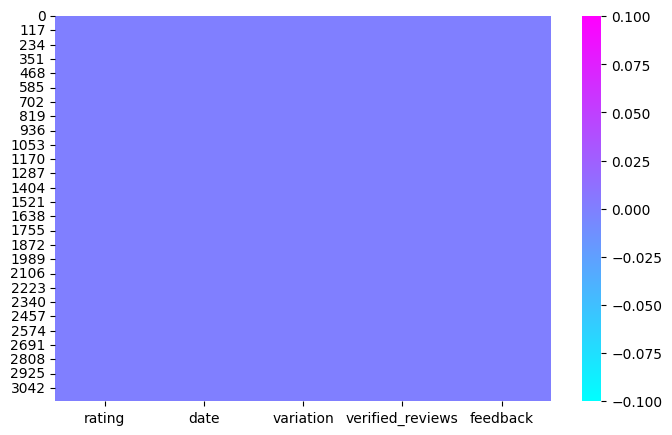

In [8]:
import seaborn as sns
plt.figure(figsize = (8,5))
sns.heatmap(data.isnull(), cmap = 'cool')
plt.show()

In [9]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [10]:
data['feedback'].nunique()

2

<AxesSubplot: xlabel='feedback', ylabel='count'>

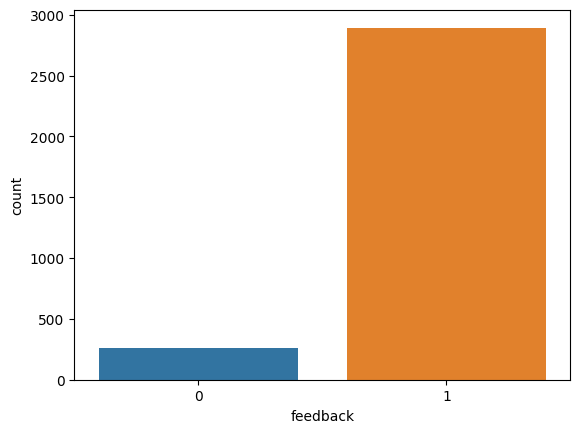

In [11]:
sns.countplot(x=data['feedback'])

In [12]:
data.duplicated().sum()

715

In [14]:
data.drop_duplicates(keep = 'last', inplace =True)

In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,2435.0,4.435318,1.109562,1.0,4.0,5.0,5.0,5.0
feedback,2435.0,0.909240,0.287326,0.0,1.0,1.0,1.0,1.0


In [17]:
data.groupby('feedback').describe()

rating                                             
           count      mean       std  min  25%  50%  75%  max
feedback                                                     
0          221.0  1.361991  0.481667  1.0  1.0  1.0  2.0  2.0
1         2214.0  4.742096  0.541849  3.0  5.0  5.0  5.0  5.0

TypeError: countplot() got multiple values for argument 'data'

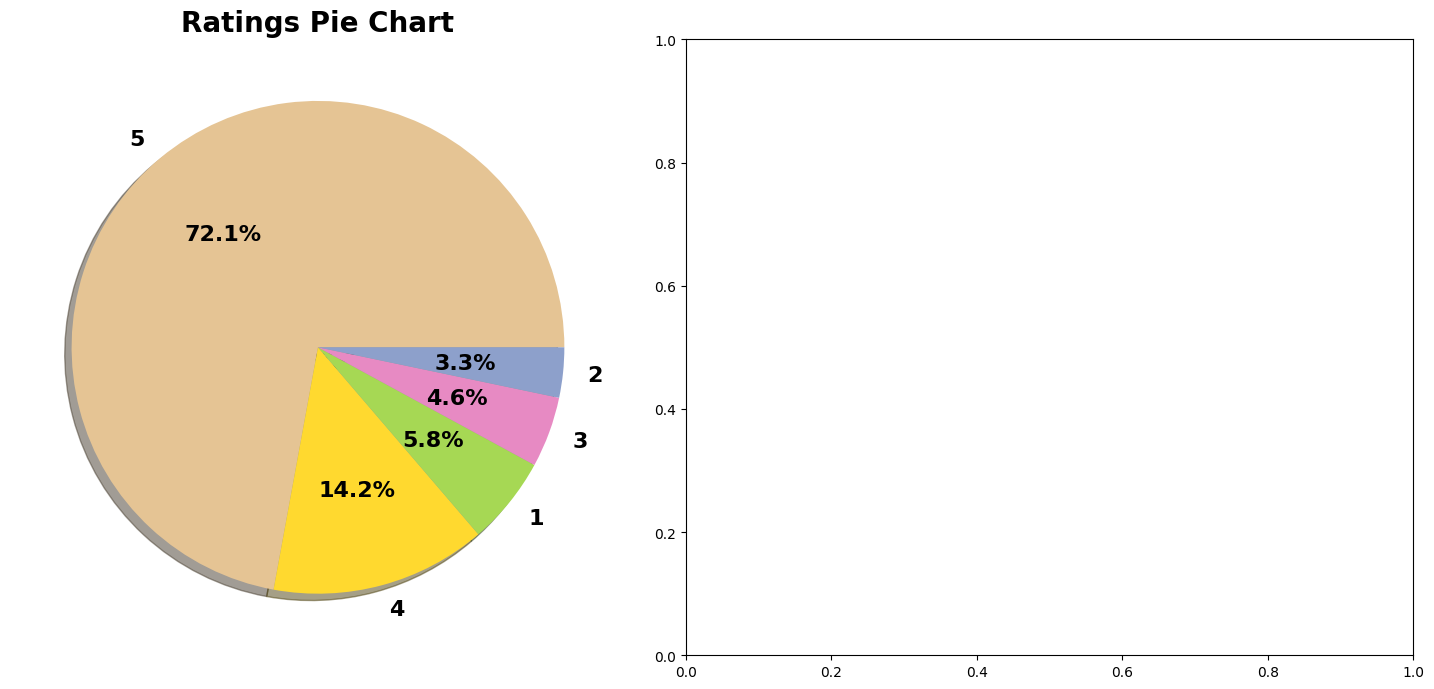

In [20]:
plt.rcParams["figure.autolayout"] = True
sns.set_palette('Set2_r')
f,ax=plt.subplots(1,2,figsize=(15,7))
data['rating'].value_counts().plot.pie(autopct='%2.1f%%',
                                textprops ={'fontsize':16 ,'fontweight' :'bold'}, ax=ax[0],shadow=True)
ax[0].set_title('Ratings Pie Chart', fontsize=20,fontweight ='bold')
ax[0].set_ylabel('')
sns.countplot('rating', data=data,ax=ax[1])
ax[1].set_title('Ratings Distribution',fontsize=18,fontweight ='bold')
ax[1].set_xlabel("Ratings",fontsize=18,fontweight ='bold')
ax[1].set_ylabel("No. of Review",fontsize=18,fontweight ='bold')
plt.xticks(fontsize=18,fontweight ='bold')
plt.tight_layout()
plt.show()
print('Value Counts of Rating:')
data['rating'].value_counts()

<AxesSubplot: xlabel='rating', ylabel='count'>

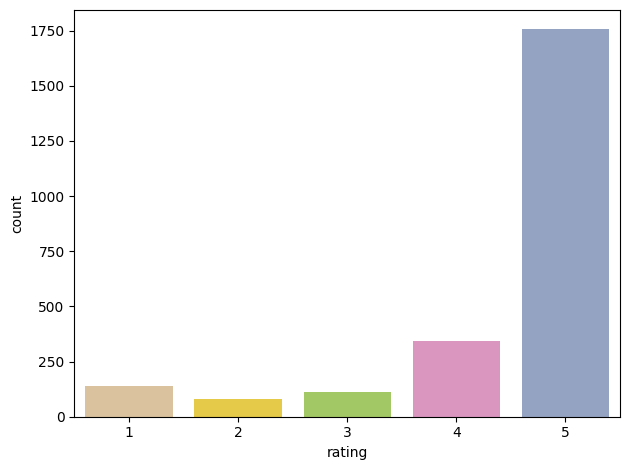

In [21]:
sns.countplot(x=data['rating'])

In [22]:
print('Value Counts of Rating:')
data['rating'].value_counts()

Value Counts of Rating:


5    1756
4     345
1     141
3     113
2      80
Name: rating, dtype: int64

In [23]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


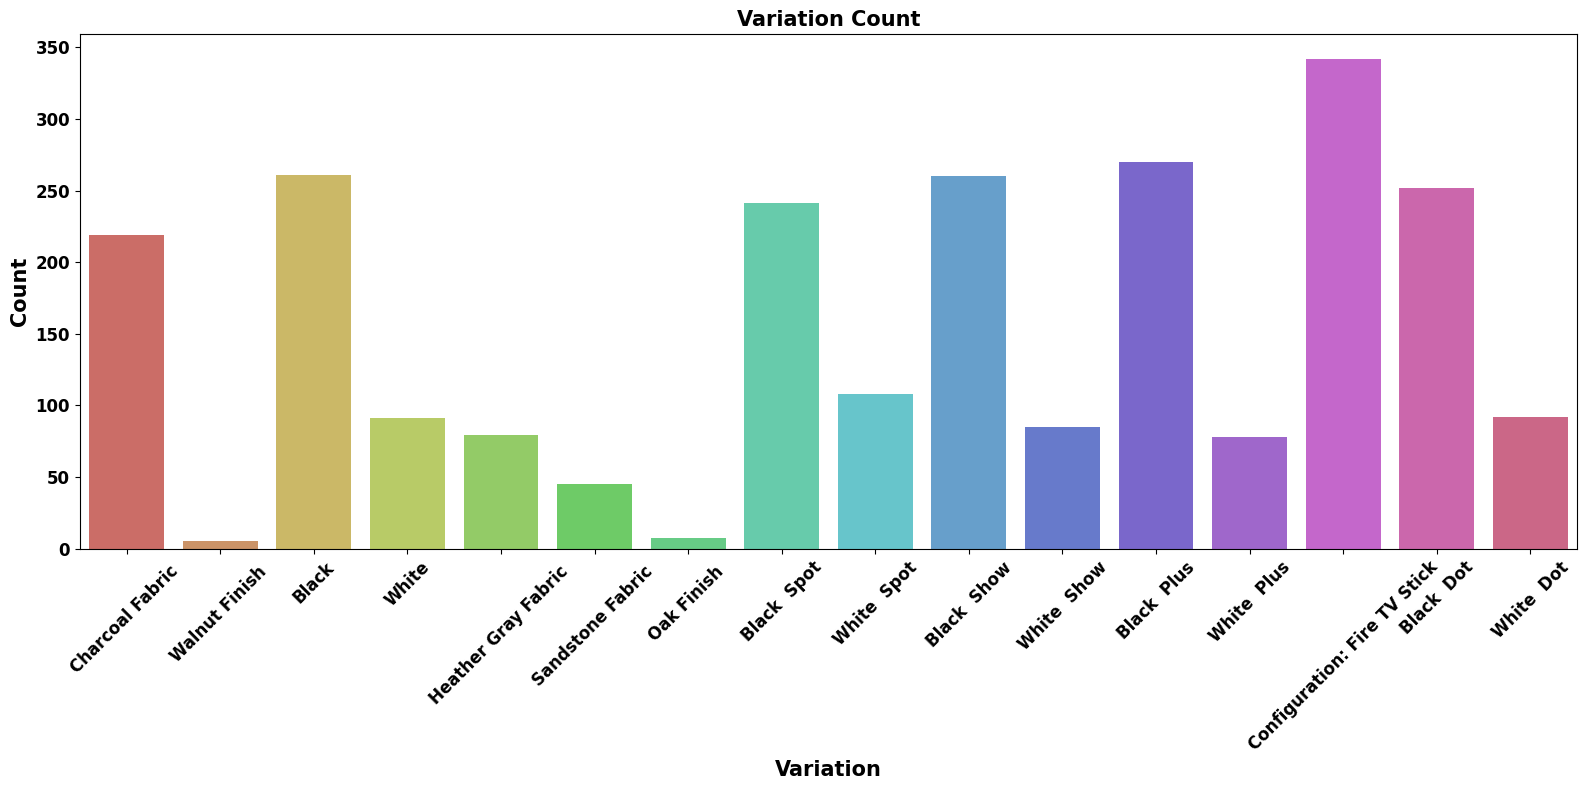

In [24]:
plt.figure(figsize=(16,8))
sns.countplot(x='variation', data=data, palette="hls")
plt.xlabel("Variation", fontsize=15, fontweight = 'bold') #seting the xtitle and size
plt.ylabel("Count", fontsize=15, fontweight = 'bold') # Seting the ytitle and size
plt.title("Variation Count", fontsize=15, fontweight = 'bold') 
plt.xticks(fontsize=12, fontweight = 'bold')
plt.yticks(fontsize=12, fontweight = 'bold')
plt.xticks(rotation=45, fontweight = 'bold')
plt.show()

In [25]:
data['length'] = data['verified_reviews'].apply(len)

/tmp/ipykernel_34/3860245642.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(data["length"][(data["rating"] == 1) & (data["length"].notnull())], color="Red", shade = True)
/tmp/ipykernel_34/3860245642.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(data["length"][(data["rating"] == 2) & (data["length"].notnull())], ax =g, color="Blue", shade= True)
/tmp/ipykernel_34/3860245642.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(data["length"][(data["rating"] == 3) & (data["length"].notnull())], color="Green", shade = True)
/tmp/ipykernel_34/3860245642.py:5: FutureWarning: 

`shade` is now deprecated i

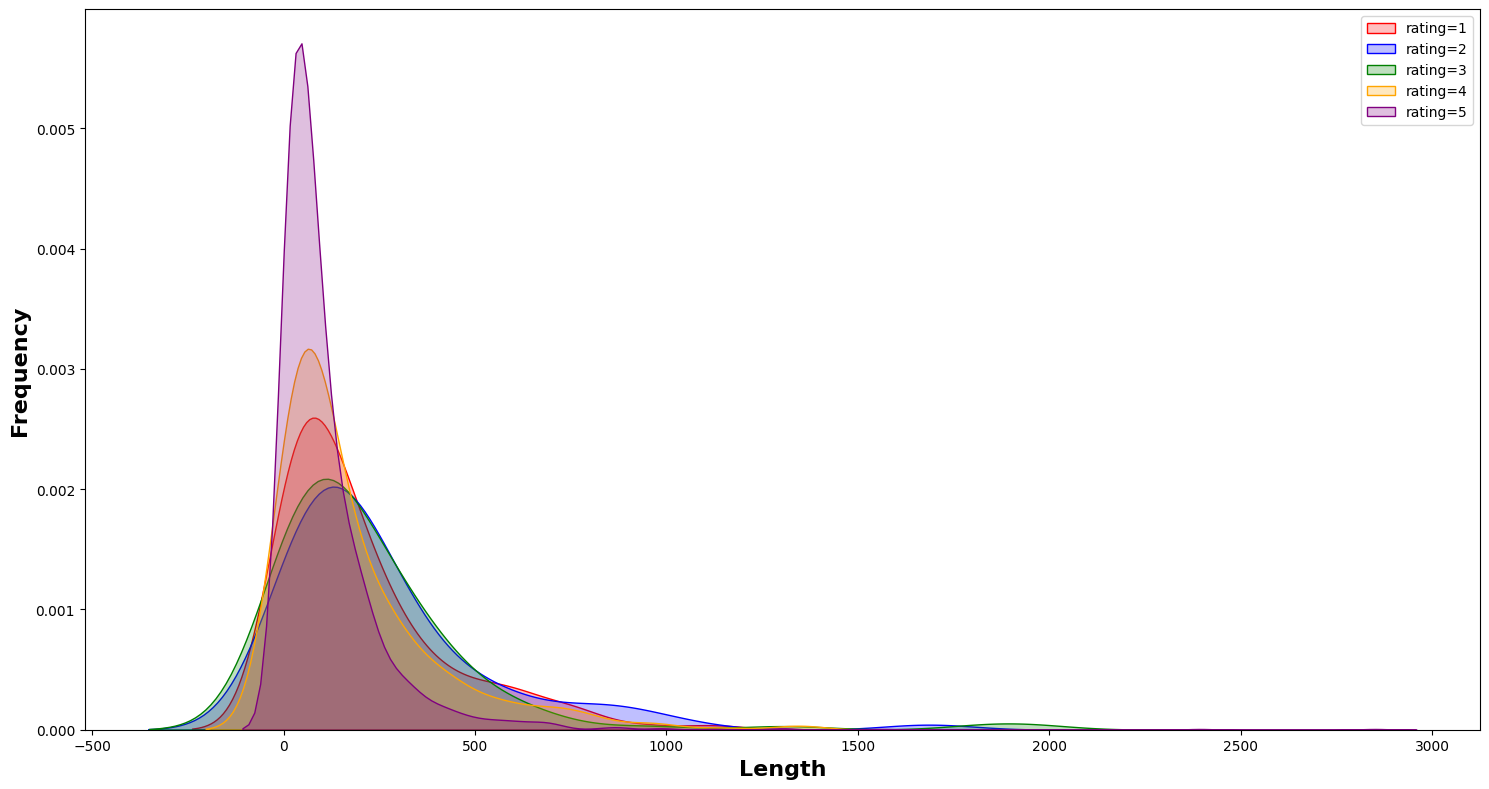

In [26]:
plt.figure(figsize=(15, 8))
g = sns.kdeplot(data["length"][(data["rating"] == 1) & (data["length"].notnull())], color="Red", shade = True)
g = sns.kdeplot(data["length"][(data["rating"] == 2) & (data["length"].notnull())], ax =g, color="Blue", shade= True)
g = sns.kdeplot(data["length"][(data["rating"] == 3) & (data["length"].notnull())], color="Green", shade = True)
g = sns.kdeplot(data["length"][(data["rating"] == 4) & (data["length"].notnull())], color="Orange", shade = True)
g = sns.kdeplot(data["length"][(data["rating"] == 5) & (data["length"].notnull())], color="Purple", shade = True)
g.set_xlabel("Length", fontsize=16, fontweight = 'bold')
g.set_ylabel("Frequency", fontsize=16, fontweight = 'bold')
g = g.legend(["rating=1","rating=2","rating=3","rating=4","rating=5"])

In [27]:
def sentiments(df):
    if df['rating'] > 3.0:
        return 'Positive'
    elif df['rating'] <= 3.0:
        return 'Negative'
data['sentiment'] = data.apply(sentiments, axis = 1)

In [28]:
data = data[['verified_reviews','sentiment']]

In [29]:
data.head()

,verified_reviews,sentiment
0,Love my Echo!,Positive
1,Loved it!,Positive
2,"Sometimes while playing a game, you can answer...",Positive
3,I have had a lot of fun with this thing. My 4 ...,Positive
4,Music,Positive


In [30]:
from nltk.corpus import stopwords

In [31]:
def clean_text(df, df_column_name):
    
    #Converting all messages to lowercase
    df[df_column_name] = df[df_column_name].str.lower()

    #Replace email addresses with 'email'
    df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

    #Replace URLs with 'webaddress'
    df[df_column_name] = df[df_column_name].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

    #Replace money symbols with 'dollars' (£ can by typed with ALT key + 156)
    df[df_column_name] = df[df_column_name].str.replace(r'£|\$', 'dollars')
      
    #Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    df[df_column_name] = df[df_column_name].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

    #Replace numbers with 'numbr'
    df[df_column_name] = df[df_column_name].str.replace(r'\d+(\.\d+)?', 'numbr')

    #Remove punctuation
    df[df_column_name] = df[df_column_name].str.replace(r'[^\w\d\s]', ' ')

    #Replace whitespace between terms with a single space
    df[df_column_name] = df[df_column_name].str.replace(r'\s+', ' ')

    #Remove leading and trailing whitespace
    df[df_column_name] = df[df_column_name].str.replace(r'^\s+|\s+?$', '')
    
    #Remove stopwords
    stop_words = set(stopwords.words('english') + ['u', 'ü', 'â', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
    df[df_column_name] = df[df_column_name].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [32]:
clean_text(data, 'verified_reviews')
data['verified_reviews'].tail(3)

/tmp/ipykernel_34/1588049274.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_column_name] = df[df_column_name].str.lower()
/tmp/ipykernel_34/1588049274.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')
/tmp/ipykernel_34/1588049274.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]

3147    love things running entire home tv lights ther...
3148    complaint sound quality great mostly use comma...
3149                                                 good
Name: verified_reviews, dtype: object

In [33]:
lb = LabelEncoder()
data['sentiment'] = lb.fit_transform(data['sentiment'])

/tmp/ipykernel_34/800710362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = lb.fit_transform(data['sentiment'])


In [34]:
data.head()

,verified_reviews,sentiment
0,love echo,1
1,loved,1
2,sometimes playing game answer question correct...,1
3,lot fun thing numbr yr old learns dinosaurs co...,1
4,music,1


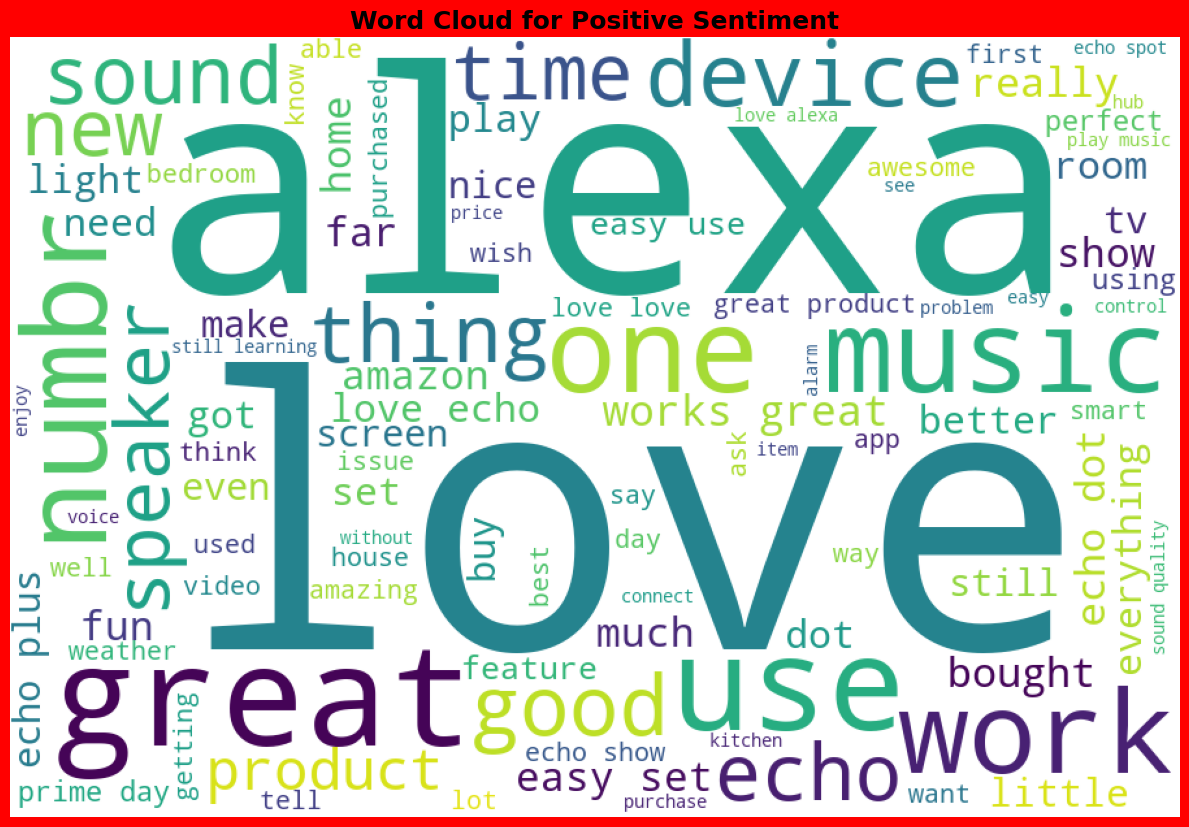

In [35]:
one = data['verified_reviews'][data['sentiment'] == 1.0]
one_cloud = wordcloud.WordCloud(width = 900, height = 600, background_color = 'white', max_words = 100).generate(' '.join(one))
plt.figure(figsize = (12,9), facecolor = 'r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment', fontsize= 18, fontweight = 'bold')
plt.tight_layout(pad = 0)
plt.show()

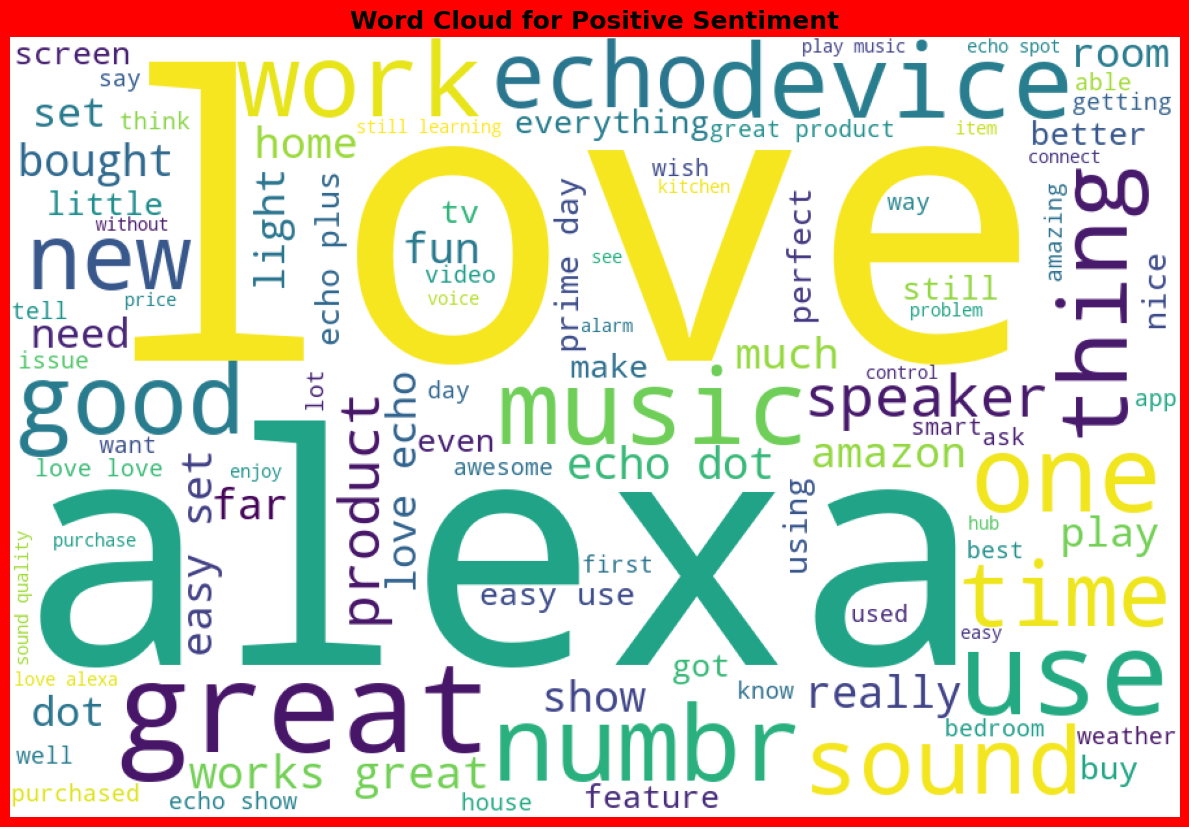

In [36]:
zero = data['verified_reviews'][data['sentiment'] == 0]
zero_cloud = wordcloud.WordCloud(width = 900, height = 600, background_color = 'white', max_words = 100).generate(' '.join(one))
plt.figure(figsize = (12,9), facecolor = 'r')
plt.imshow(zero_cloud)
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment', fontsize= 18, fontweight = 'bold')
plt.tight_layout(pad = 0)
plt.show()

In [37]:
tokenizer = Tokenizer(num_words = 1000, split = ' ')
tokenizer.fit_on_texts(data['verified_reviews'].values)
x = tokenizer.texts_to_sequences(data['verified_reviews'].values)
x = pad_sequences(x)
x

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   0, 159],
       [  0,   0,   0, ...,  65, 228,  21],
       ...,
       [  0,   0,   0, ...,  88,  43,  29],
       [  0,   0,   0, ..., 768, 647, 118],
       [  0,   0,   0, ...,   0,   0,  15]], dtype=int32)

In [38]:
x.shape[1]

234

In [43]:
from keras.layers import Bidirectional

In [47]:
model =  Sequential()
model.add(Embedding(1000,120,input_length = x.shape[1] ))
model.add(SpatialDropout1D(0.4))
#model.add(LSTM(176, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(24, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 234, 120)          120000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 234, 120)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              94720     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 24)                3096      
                                                                 
 dense_4 (Dense)             (None, 2)                 50        
                                                                 
Total params: 217,866
Trainable params: 217,866
Non-tr

In [48]:
y = pd.get_dummies(data['sentiment'])
x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size = 0.3, random_state = 99)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [50]:
model.fit(x_train, y_train, epochs=40, batch_size=64, verbose=1)

Epoch 1/40
27/27 [==============================] - 8s 289ms/step - loss: 0.1178 - accuracy: 0.9531
Epoch 2/40
27/27 [==============================] - 8s 304ms/step - loss: 0.0972 - accuracy: 0.9589
Epoch 3/40
27/27 [==============================] - 8s 294ms/step - loss: 0.0785 - accuracy: 0.9648
Epoch 4/40
27/27 [==============================] - 8s 293ms/step - loss: 0.0691 - accuracy: 0.9712
Epoch 5/40
27/27 [==============================] - 8s 291ms/step - loss: 0.0664 - accuracy: 0.9712
Epoch 6/40
27/27 [==============================] - 8s 306ms/step - loss: 0.0574 - accuracy: 0.9730
Epoch 7/40
27/27 [==============================] - 8s 293ms/step - loss: 0.0558 - accuracy: 0.9795
Epoch 8/40
27/27 [==============================] - 8s 289ms/step - loss: 0.0561 - accuracy: 0.9765
Epoch 9/40
27/27 [==============================] - 8s 295ms/step - loss: 0.0420 - accuracy: 0.9836
Epoch 10/40
27/27 [==============================] - 8s 307ms/step - loss: 0.0464 - accuracy: 0.9783

In [51]:
model.evaluate(x_test, y_test)

23/23 [==============================] - 2s 44ms/step - loss: 0.8896 - accuracy: 0.8659


[0.889624297618866, 0.8659370541572571]